# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.shape

(85, 4)

In [7]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SHOPPER_TYP,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
print('Date naturally missing: {}'.format(azdias.isnull().sum().sum()))


Date naturally missing: 4896838


In [10]:
# Identify missing or unknown data values and convert them to NaNs.
unknown = 0
for i in range(len(feat_info)):    
    missing_or_unknown = feat_info.loc[i,'missing_or_unknown'].strip('[]').split(',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        unknown += 1
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
        

In [11]:
# Show new data with "NaN"
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
print('Unknown/ missing date that got conversed: ', unknown)
print('Total date missing after conversion: {}'.format(azdias.isnull().sum().sum()))


Unknown/ missing date that got conversed:  75
Total date missing after conversion: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_per_column = azdias.isnull().sum()
percent_missing_per_column = (missing_per_column / len(azdias))*100


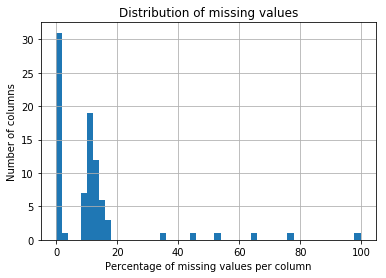

In [14]:
# Investigate patterns in the amount of missing data in each column.
# Plot distribution of missing values
plt.hist(percent_missing_per_column, bins = 50)
plt.title('Distribution of missing values')
plt.xlabel('Percentage of missing values per column')
plt.ylabel('Number of columns')
plt.grid()
plt.show()


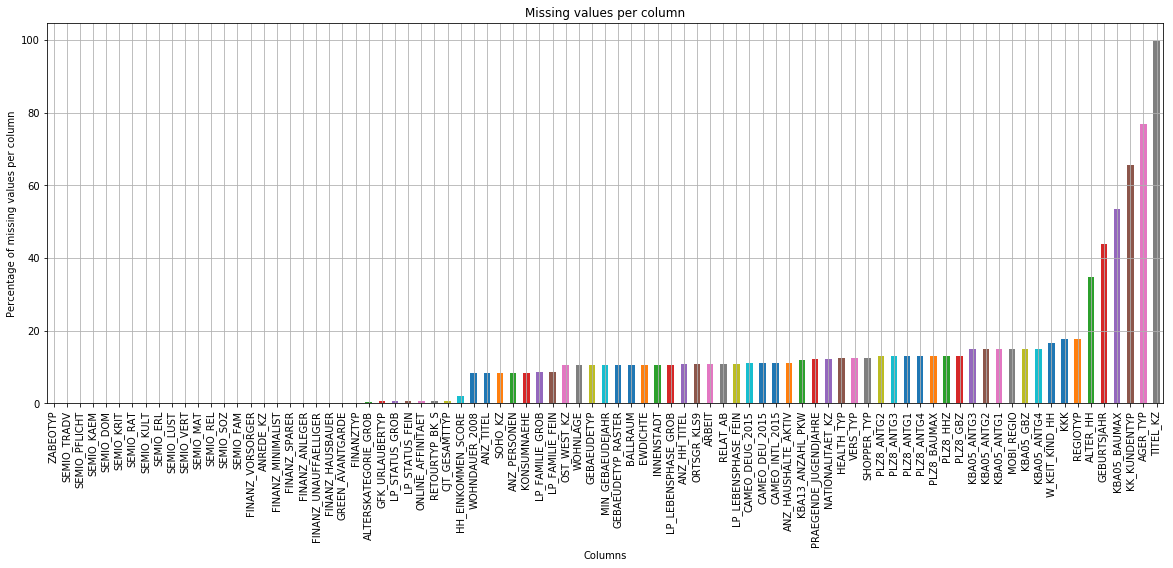

In [15]:
# Investigate patterns in the amount of missing data in each column.
# Plot percentage of missing data per column 
missing_columns_sorted = percent_missing_per_column.sort_values()
missing_columns_sorted.plot.bar(figsize = (20, 7))
plt.title('Missing values per column')
plt.xlabel('Columns')
plt.ylabel('Percentage of missing values per column')
plt.grid()
plt.show()


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = azdias.loc[:, percent_missing_per_column > 20]
outlier_columns.head()


,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1996.0,NaN,NaN,NaN,5.0
2,NaN,1979.0,NaN,17.0,NaN,NaN
3,2.0,1957.0,NaN,13.0,NaN,1.0
4,NaN,1963.0,NaN,20.0,1.0,NaN


In [17]:
# Remove outlier columns from dataset
azdias = azdias.drop(outlier_columns, axis=1)
azdias.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

In the diagramms two things are easy to figure out:

- around half of all columns miss between 5 to 20% of their values --> if we define these as outliers, we lose lots of data
- only 6 columns miss more than 20% of their values --> these columns can be defined as outliers and have to be removed

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)
missing_per_row.head(20)


0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
dtype: int64

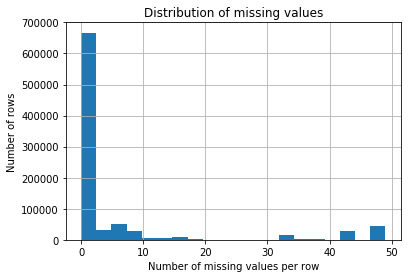

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
plt.hist(missing_per_row, bins = 20)
plt.title('Distribution of missing values')
plt.xlabel('Number of missing values per row')
plt.ylabel('Number of rows')
plt.grid()
plt.show()


In the diagramms two things can be figured out:

- a huge number of rows has no missing data at all
- there is a small amount of rows with less than 10 missing data
- the rest of the data (missing for more than 10 values) is quite small and there seems to be a peek between 40 and 50 missing values.

A good decision to devide the data up is at the threshold of 10

In [20]:
threshold = 10
azdias_few_missing = azdias[missing_per_row < threshold]
azdias_many_missing = azdias[missing_per_row >= threshold]
azdias_few_missing.shape


(774743, 79)

GFK_URLAUBERTYP


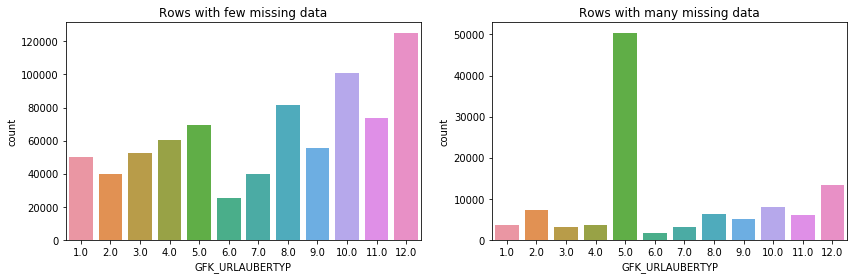

PRAEGENDE_JUGENDJAHRE


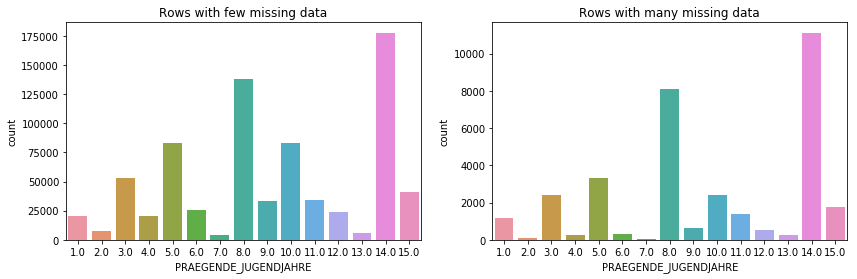

SEMIO_RAT


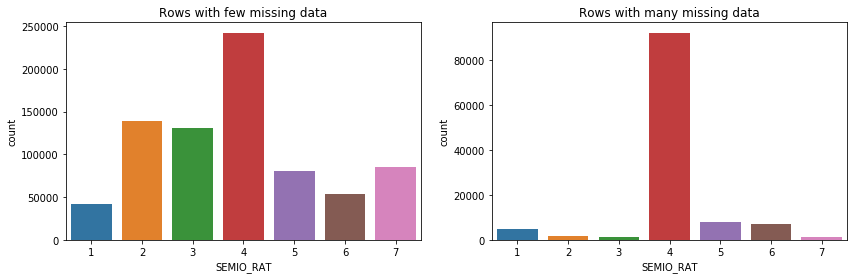

ANZ_PERSONEN


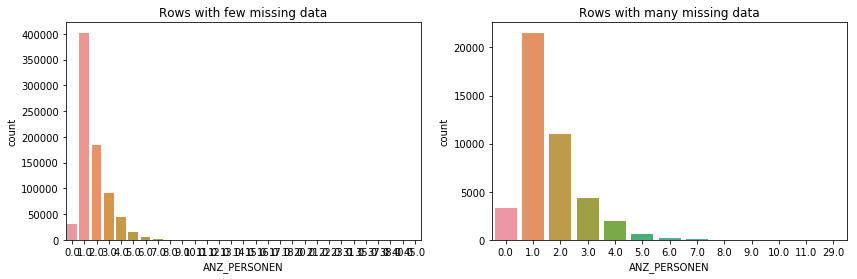

OST_WEST_KZ


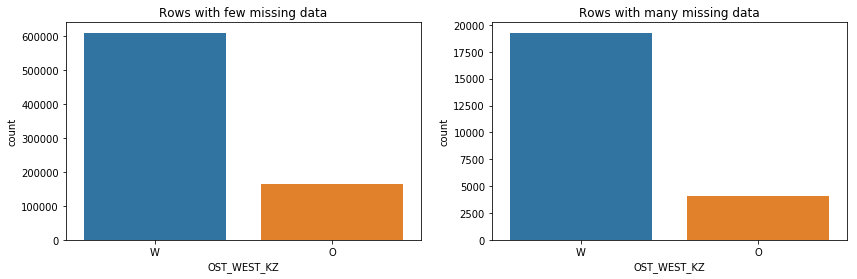

In [284]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution(column_name):
    graph = plt.figure(figsize=(14,4))
    ax1 = graph.add_subplot(121)
    ax1.title.set_text('Rows with few missing data')
    sns.countplot(azdias.loc[azdias_few_missing.index,str(sample_columns)])

    ax2 = graph.add_subplot(122)
    ax2.title.set_text('Rows with many missing data')
    sns.countplot(azdias.loc[azdias_many_missing.index,str(sample_columns)]);
    
    plt.show()

    
#Columns for comparison are no. 10, 20, 30, 40, 50
selected_five = []
for five in range(10,60,10):
    selected_five.append(azdias.columns[five])

for sample_columns in selected_five:
    print(sample_columns)
    compare_distribution(sample_columns)
    

#### Discussion 1.1.3: Assess Missing Data in Each Row

The diagramms show two different perspectives: 

- Many diagramms are very similar, whether they derive from the data with few missing data or the data of many missing data
- There are some diagramms, that differ quite a lot (e.g. finanze, semio). This might be due to the german mentality to not talk about finanzial topics to other persons.

The analysis will be continued with the subset of the data with few missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical


array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [24]:
# Dropout outlier columns as identified in 1.1.2
categorical = [i for i in categorical if i in azdias.columns]
categorical


['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [25]:
# Identify binary attributes within categorical variables
categorical_binary = [i for i in categorical if azdias[i].nunique() == 2]
categorical_binary


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [26]:
for feature in categorical_binary:
    print('{} has the values: {}'.format(feature, azdias_few_missing[feature].unique()))
    

ANREDE_KZ has the values: [2 1]
GREEN_AVANTGARDE has the values: [0 1]
SOHO_KZ has the values: [ 1.  0.]
VERS_TYP has the values: [  2.   1.  nan]
OST_WEST_KZ has the values: ['W' 'O']


In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Changing 'W' --> 0 and 'O' --> 1
azdias_few_missing.loc[:, 'OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [28]:
# Identify multi_level attributes within categorical variables
categorical_multi_level = [i for i in categorical if azdias[i].nunique() > 2]
categorical_multi_level


['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [29]:
# Drop multi-level features
for feature in categorical_multi_level:
    azdias_few_missing=azdias_few_missing.drop(feature, axis=1)
    

#### Discussion 1.2.1: Re-Encode Categorical Features

- First: identify all categorical variables
- Dropout outlier columns as identified in 1.1.2
- Identify binary variables (5) and search for the one variable, that has to be re-encoded --> OST_WEST_KZ
- Replace 'W' by '0' and 'O' by '1'

- Identify multi-level variables (13) and drop them out to keep things simple.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info[feat_info['type'] == 'mixed']


,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


Logic of distribution:

-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [31]:
# Replacement for decade
# 40s = 1; 50s = 2; 60s = 3; 70s = 4; 80s = 5, 90s = 6
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE']
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_dict, inplace=True)

# Replacement for movement
# Avantgarde = 0; Mainstream = 1
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE']
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement_dict, inplace=True)


In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

Logic of distribution:
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Replacement for wealth
# Wealthy = 1; Prosperous = 2; Comfortable = 3; Less Affluent = 4; Poorer = 5
azdias_few_missing['CAMEO_INTL_2015_WEALTH'] = azdias_few_missing['CAMEO_INTL_2015']
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
azdias_few_missing['CAMEO_INTL_2015_WEALTH'].replace(wealth_dict, inplace=True)


In [34]:
# Replacement for LIFE_STAGE
# Pre-Family Couples & Singles = 1; Young Couples With Children = 2; Families With School Age Children = 3; 
# Older Families & Mature Couples = 4; Elders In Retirement = 5
azdias_few_missing['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_few_missing['CAMEO_INTL_2015']
life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
azdias_few_missing['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage_dict, inplace=True)


In [35]:
# Drop out replaced columns:
azdias_few_missing.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)


In [36]:
feat_info[feat_info['type'] == 'mixed']


,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [37]:
# Drop out all other columns with mixed-type features:
azdias_few_missing.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)


#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE:
- First: Initiate a copy of the column 'PRAEGENDE_JUGENDJAHRE' for 'decade'
- Define the dictionary by looking in Data_Dictionary.md
- Replace old values with new ones out of own dictionary
- Repeat procedure for 'movement'

CAMEO_INTL_2015:
- First: Initiate a copy of the column 'CAMEO_INTL_2015' for 'wealth'
- Define the dictionary by looking in Data_Dictionary.md
- Replace old values with new ones out of own dictionary
- Repeat procedure for 'life stage'

Drop out replaced columns.
Other mixed_type features are represented by other columns and therefor will be dropped out.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [285]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_few_missing.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_few_missing.shape

(774743, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # Load in the feature summary file.
    feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
    
    # Identify missing or unknown data values and convert them to NaNs. (--> 1.1.1)
    unknown = 0
    for i in range(len(feat_info)):    
        missing_or_unknown = feat_info.loc[i,'missing_or_unknown'].strip('[]').split(',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            unknown += 1
            df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    print('Unknown/ missing date that got conversed: ', unknown)
    print('Total date missing after conversion: {}'.format(df.isnull().sum().sum()))
        
    # Remove the outlier columns from the dataset like previously removed. (--> 1.1.2)
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(outlier_columns, axis=1)

    # Fokus on rows with few missing data. (--> 1.1.3)
    missing_per_row = df.isnull().sum(axis=1)
    threshold = 10
    df_few_missing = df[missing_per_row < threshold]
    
    # select, re-encode, and engineer column values. (--> 1.2.1)
    # Re-encode binary variables
    # Changing 'W' --> 0 and 'O' --> 1
    df_few_missing.loc[:, 'OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)
        
    # Drop out multi-level features
    categorical_multi_level = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                               'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                                'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    for feature in categorical_multi_level:
        df_few_missing = df_few_missing.drop(feature, axis=1)
        
    # Engineer Mixed-Type Features. (--> 1.2.2)
    # First: PRAEGENDE_JUGENDJAHRE
    # Replacement for decade
    # 40s = 1; 50s = 2; 60s = 3; 70s = 4; 80s = 5, 90s = 6
    df_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_few_missing['PRAEGENDE_JUGENDJAHRE']
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_dict, inplace=True)

    # Replacement for movement
    # Avantgarde = 0; Mainstream = 1
    df_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_few_missing['PRAEGENDE_JUGENDJAHRE']
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement_dict, inplace=True)
    
    # Second: CAMEO_INTL_2015
    # Replacement for wealth
    # Wealthy = 1; Prosperous = 2; Comfortable = 3; Less Affluent = 4; Poorer = 5
    df_few_missing['CAMEO_INTL_2015_WEALTH'] = df_few_missing['CAMEO_INTL_2015']
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    df_few_missing['CAMEO_INTL_2015_WEALTH'].replace(wealth_dict, inplace=True)
    
    # Replacement for LIFE_STAGE
    # Pre-Family Couples & Singles = 1; Young Couples With Children = 2; Families With School Age Children = 3; 
    # Older Families & Mature Couples = 4; Elders In Retirement = 5
    df_few_missing['CAMEO_INTL_2015_LIFE_STAGE'] = df_few_missing['CAMEO_INTL_2015']
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df_few_missing['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    # Drop out replaced columns:
    df_few_missing.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis = 1, inplace = True)
    
    # Drop out all other columns with mixed-type features:
    df_few_missing.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_few_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

imputer = Imputer()     #default: missing_value = np.nan; strategy = mean
azdias_few_missing_imputer = pd.DataFrame(imputer.fit_transform(azdias_few_missing), 
                                          index = azdias_few_missing.index, 
                                          columns = azdias_few_missing.columns)


In [42]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_few_missing_imputer_scaler = pd.DataFrame(scaler.fit_transform(azdias_few_missing_imputer), 
                                                 columns = azdias_few_missing_imputer.columns)


In [43]:
print(type(azdias_few_missing_imputer_scaler))

<class 'pandas.core.frame.DataFrame'>


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)
- Apply "Imputer" with the default values of "missing_value = np.nan; strategy = mean"
- Apply "StandardScaler" to achive feature scaling on the complete data.
- Quickcheck if everything was made correctly

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
azdias_few_missing_imputer_scaler_pca = pca.fit_transform(azdias_few_missing_imputer_scaler)


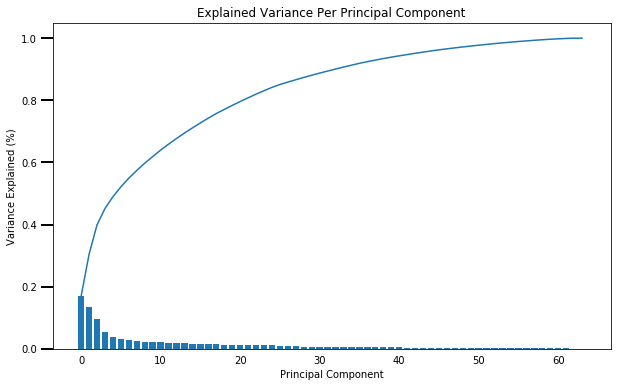

In [286]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


In [46]:
# List of variances over number of components
for i in np.arange(10, 70, 10):
    print('For {} components, explained variance:'.format(i), pca.explained_variance_ratio_[:i].sum())


For 10 components, explained variance: 0.618680148614
For 20 components, explained variance: 0.783506268628
For 30 components, explained variance: 0.880715010359
For 40 components, explained variance: 0.938814534683
For 50 components, explained variance: 0.974637173791
For 60 components, explained variance: 0.996566228553


In [47]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components = 30)
azdias_pca_30 = pca_30.fit_transform(azdias_few_missing_imputer_scaler_pca)


In [50]:
# Check
print('Date naturally missing: {}'.format(azdias_few_missing_imputer_scaler.isnull().sum().sum()))

Date naturally missing: 0


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- Import PCA from sklearn an apply it to data
- Use plot-function and list of veriances over number of component to find sweet spot.
- To reach around 90%, 30 components are the right choise.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [55]:
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.

def pca_results(df, pca, component_no, features_no, show_plot=True):
    
    # Build a dataframe with features_no features capturing most variability
    # for a given component number (component_no)
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending = False, inplace = True)
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
   
    return pca_comp


In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_results(azdias_few_missing_imputer_scaler, pca, 0, 5)
print(res)


SEMIO_TRADV                       0.0128
SEMIO_VERT                        0.0080
ONLINE_AFFINITAET                 0.0080
HH_EINKOMMEN_SCORE                0.0061
SEMIO_KULT                        0.0045
SEMIO_PFLICHT                    -0.0174
SEMIO_REL                        -0.0348
ALTERSKATEGORIE_GROB             -0.0429
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.7040
GREEN_AVANTGARDE                 -0.7068
Name: 63, dtype: float64


In [57]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_results(azdias_few_missing_imputer_scaler, pca, 1, 5)
print(res)


PLZ8_ANTG3                0.2269
PLZ8_ANTG4                0.2200
CAMEO_INTL_2015_WEALTH    0.2078
HH_EINKOMMEN_SCORE        0.2044
ORTSGR_KLS9               0.1976
KBA05_GBZ                -0.2174
FINANZ_MINIMALIST        -0.2186
KBA05_ANTG1              -0.2258
PLZ8_ANTG1               -0.2265
MOBI_REGIO               -0.2423
Name: 0, dtype: float64


In [58]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_results(azdias_few_missing_imputer_scaler, pca, 2, 5)
print(res)


ALTERSKATEGORIE_GROB            0.2605
FINANZ_VORSORGER                0.2332
SEMIO_ERL                       0.2308
SEMIO_LUST                      0.1831
RETOURTYP_BK_S                  0.1646
SEMIO_PFLICHT                  -0.2295
SEMIO_TRADV                    -0.2316
FINANZ_SPARER                  -0.2363
PRAEGENDE_JUGENDJAHRE_DECADE   -0.2515
SEMIO_REL                      -0.2557
Name: 1, dtype: float64


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Component 1:
The first principle componente is positiv related with:
- SEMIO_TRADV                       0.0128 (tradional-minded)
- SEMIO_VERT                        0.0080 (dreamful)
- ONLINE_AFFINITAET                 0.0080 (online affinity)
- HH_EINKOMMEN_SCORE                0.0061 (Estimated household net income --> große Zahl = wenig Geld!)
- SEMIO_KULT                        0.0045 (cultural-minded)

And negativ related with
- SEMIO_PFLICHT                    -0.0174 (dutiful)
- SEMIO_REL                        -0.0348 (religious)
- ALTERSKATEGORIE_GROB             -0.0429 (young??????????????)
- PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.7040 (elder???????????????)
- GREEN_AVANTGARDE                 -0.7068 (Membership in environmental sustainability as part of youth)

Component 2:
The second principle componente is positiv related with:
- PLZ8_ANTG3                0.2269 (Number of 6-10 family houses in the PLZ8 region)
- PLZ8_ANTG4                0.2200 (Number of 10+ family houses in the PLZ8 region)
- CAMEO_INTL_2015_WEALTH    0.2078 (German CAMEO: Wealth / Life Stage Typology, mapped to international code)
- HH_EINKOMMEN_SCORE        0.2044 (Estimated household net income --> große Zahl = wenig Geld!)
- ORTSGR_KLS9               0.1976 (Size of community)

And negativ related with
- KBA05_GBZ                -0.2174 (Number of buildings in the microcell)
- FINANZ_MINIMALIST        -0.2186 (low financial interest)
- KBA05_ANTG1              -0.2258 (Number of 1-2 family houses in the microcell)
- PLZ8_ANTG1               -0.2265 (Number of 1-2 family houses in the PLZ8 region)
- MOBI_REGIO               -0.2423 (Movement patterns)

Component 3:
The third principle componente is positiv related with:
- ALTERSKATEGORIE_GROB            0.2605 (Estimated age based on given name analysis)
- FINANZ_VORSORGER                0.2332 (be prepared)
- SEMIO_ERL                       0.2308 (event-oriented)
- SEMIO_LUST                      0.1831 (sensual-minded)
- RETOURTYP_BK_S                  0.1646 (Return type)

And negativ related with
- SEMIO_PFLICHT                  -0.2295 (dutiful)
- SEMIO_TRADV                    -0.2316 (tradional-minded)
- FINANZ_SPARER                  -0.2363 (money-saver)
- PRAEGENDE_JUGENDJAHRE_DECADE   -0.2515 (Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west))
- SEMIO_REL                      -0.2557 (religious)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [176]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

scores = []
for i in range(2,30):
    # run k-means clustering on the data and...
    kmeans = MiniBatchKMeans(n_clusters=i)
    kmeans.fit(azdias_pca_30)
    
    # compute the average within-cluster distances.
    print('The distance (Score) for {} clusters is: {}'.format(i, kmeans.score(azdias_pca_30)))
    scores.append(-kmeans.score(azdias_pca_30))
    

The distance (Score) for 2 clusters is: -37352623.5231003
The distance (Score) for 3 clusters is: -34562295.646108896
The distance (Score) for 4 clusters is: -33036122.806719914
The distance (Score) for 5 clusters is: -30712391.965948533
The distance (Score) for 6 clusters is: -29966100.87776489
The distance (Score) for 7 clusters is: -28478411.28134365
The distance (Score) for 8 clusters is: -28504007.23841182
The distance (Score) for 9 clusters is: -27398182.57277493
The distance (Score) for 10 clusters is: -26889550.569811597
The distance (Score) for 11 clusters is: -25814292.79820509
The distance (Score) for 12 clusters is: -25751158.01281585
The distance (Score) for 13 clusters is: -25260112.136130065
The distance (Score) for 14 clusters is: -25216375.520174794
The distance (Score) for 15 clusters is: -25135953.373195425
The distance (Score) for 16 clusters is: -24333362.16495968
The distance (Score) for 17 clusters is: -24335894.238892905
The distance (Score) for 18 clusters is: 

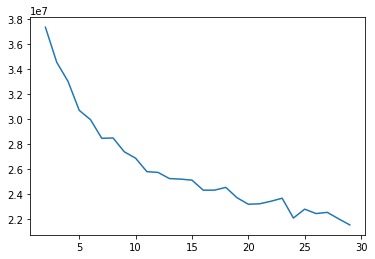

In [177]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
import matplotlib.pyplot as plt

centers = list(range(2,30))
plt.plot(centers, scores)


In [245]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_12 = KMeans(n_clusters = 12)
model_12 = kmeans.fit(azdias_pca_30)
azdias_predict = model_12.predict(azdias_pca_30)


### Discussion 3.1: Apply Clustering to General Population

For KMean clustering is a timeconsuming task, I choose MiniBatchKMean to get it faster.

There is no clear evidence, where to find the elbow of the function. To me it seems, that around 12 clusters the curve flattens.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [246]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.shape


(191652, 85)

In [247]:
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [248]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_few_missing = clean_data(customers)


Unknown/ missing date that got conversed:  75
Total date missing after conversion: 3112918


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [249]:
customers_few_missing.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [251]:
# Impute means (using '.transform' as discussed in forum)
customers_few_missing_imputer = pd.DataFrame(imputer.transform(customers_few_missing), 
                                          index = customers_few_missing.index, 
                                          columns = customers_few_missing.columns)


In [252]:
customers_few_missing_imputer.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,2.0,0.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,2.0,0.0,3.0,4.0


In [253]:
# Standardize/ Feature Scaling (using '.transform' as discussed in forum)

customers_few_missing_imputer_scaler = pd.DataFrame(scaler.transform(customers_few_missing_imputer), 
                                                 columns = customers_few_missing_imputer.columns)


In [254]:
customers_few_missing_imputer_scaler.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.181742,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.818216,1.882757,-1.629936,...,-0.967205,1.432085,1.464805,-2.186657,-1.439900,-1.533713,-1.621012,-1.873696,-1.555604,0.087197
1,1.181742,0.958422,1.415239,-1.151076,1.133590,-1.247929,0.981043,0.612067,1.882757,-0.276069,...,0.414545,-0.632597,-1.247491,-0.175332,-0.133626,-0.058527,-1.621012,-1.873696,-0.187928,0.760743
2,1.181742,-1.043381,1.415239,-1.151076,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.276069,...,-0.967205,-0.632597,0.560706,-2.186657,-1.004475,-1.533713,-2.318322,0.551870,-0.871766,0.760743
3,0.199492,-1.043381,-0.036773,-1.151076,0.407498,0.789423,1.698711,-0.818216,-0.531136,1.077799,...,0.414545,-0.632597,-0.343393,-0.175332,-0.133626,-1.533713,-0.226391,0.551870,0.495910,-1.259894
4,0.199492,-1.043381,1.415239,-1.151076,1.133590,-1.247929,-0.454293,-0.103075,1.882757,1.077799,...,0.414545,1.432085,1.464805,-0.175332,0.737224,1.416660,-1.621012,-1.873696,-0.187928,0.760743


In [255]:
# PCA transformation (using '.transform' as discussed in forum)
customers_pca_30 = pca_30.transform(customers_few_missing_imputer_scaler)


In [256]:
# Apply kMean clustering on customers dataset
customers_predict = kmeans.predict(customers_pca_30)


In [257]:
# Test first component
res = pca_results(customers_few_missing_imputer_scaler, pca, 0, 5)
print(res)


SEMIO_TRADV                       0.0128
SEMIO_VERT                        0.0080
ONLINE_AFFINITAET                 0.0080
HH_EINKOMMEN_SCORE                0.0061
SEMIO_KULT                        0.0045
SEMIO_PFLICHT                    -0.0174
SEMIO_REL                        -0.0348
ALTERSKATEGORIE_GROB             -0.0429
PRAEGENDE_JUGENDJAHRE_MOVEMENT   -0.7040
GREEN_AVANTGARDE                 -0.7068
Name: 63, dtype: float64


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [258]:
azdias_predict
print(type(azdias_predict))


<class 'numpy.ndarray'>


In [259]:
customers_predict


array([14, 22, 22, ..., 22,  1, 11], dtype=int32)

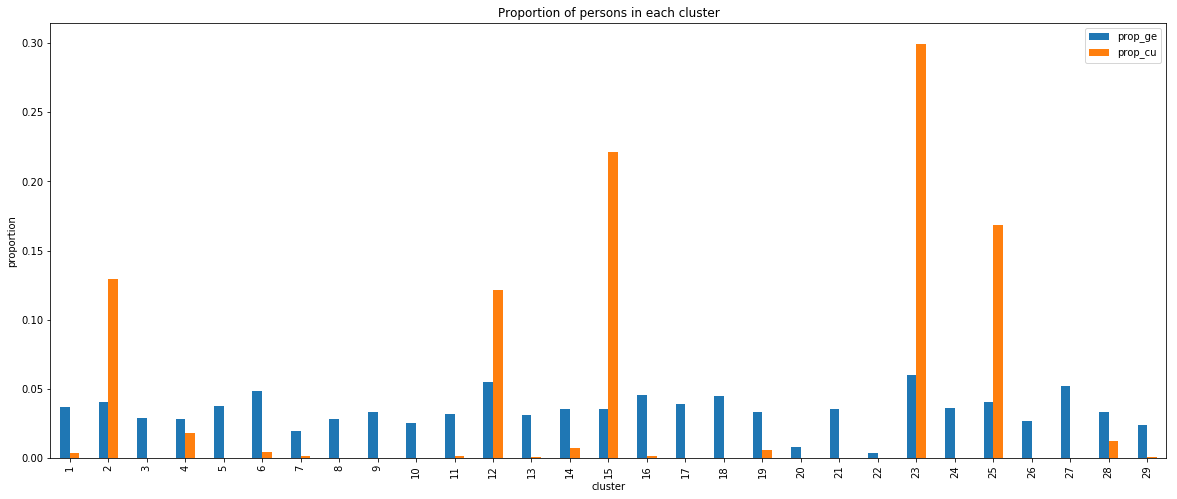

In [280]:
# Show 29 clusters in the graph
proportion_general = []
proportion_customers = []

x = [i+1 for i in range(29)] 
for i in range(29):
    proportion_general.append((azdias_predict == i).sum()/len(azdias_predict))
    proportion_customers.append((customers_predict == i).sum()/len(customers_predict))

df_plot = pd.DataFrame({'cluster' : x, 'prop_ge' : proportion_general, 'prop_cu':proportion_customers})
df_plot.plot(x='cluster', y = ['prop_ge', 'prop_cu'], kind='bar', figsize=(20,8))

plt.title('Proportion of persons in each cluster')
plt.ylabel('proportion')
plt.show()


In [290]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_15 = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[15]))
customers_overrep = pd.Series(data = centroid_15, index = customers_few_missing.columns)
customers_overrep


ALTERSKATEGORIE_GROB                 1.515157
ANREDE_KZ                           -0.262059
FINANZ_MINIMALIST                   -1.199145
FINANZ_SPARER                        1.226134
FINANZ_VORSORGER                     4.183826
FINANZ_ANLEGER                       3.111517
FINANZ_UNAUFFAELLIGER                2.022886
FINANZ_HAUSBAUER                     2.065056
GREEN_AVANTGARDE                     0.534070
HEALTH_TYP                           2.312934
RETOURTYP_BK_S                       3.327100
SEMIO_SOZ                            4.294900
SEMIO_FAM                            4.362660
SEMIO_REL                            3.686395
SEMIO_MAT                            4.513363
SEMIO_VERT                           4.163357
SEMIO_LUST                           4.129354
SEMIO_ERL                            4.542318
SEMIO_KULT                           4.200070
SEMIO_RAT                            4.162032
SEMIO_KRIT                           4.479659
SEMIO_DOM                         

In [289]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_16 = scaler.inverse_transform(pca_30.inverse_transform(model_12.cluster_centers_[16]))
customers_underrep = pd.Series(data = centroid_16, index = customers_few_missing.columns)
customers_underrep


ALTERSKATEGORIE_GROB                 7.112750
ANREDE_KZ                           -0.031935
FINANZ_MINIMALIST                    6.624151
FINANZ_SPARER                        2.870582
FINANZ_VORSORGER                     3.781585
FINANZ_ANLEGER                       1.237290
FINANZ_UNAUFFAELLIGER                2.284301
FINANZ_HAUSBAUER                     3.665476
GREEN_AVANTGARDE                     0.137494
HEALTH_TYP                           2.255612
RETOURTYP_BK_S                       4.042740
SEMIO_SOZ                            4.113340
SEMIO_FAM                            4.017637
SEMIO_REL                            4.448519
SEMIO_MAT                            4.077098
SEMIO_VERT                           4.548620
SEMIO_LUST                           4.173123
SEMIO_ERL                            4.888074
SEMIO_KULT                           4.192634
SEMIO_RAT                            3.882281
SEMIO_KRIT                           4.640999
SEMIO_DOM                         

##### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Overrepresented: Cluster 15
- ALTERSKATEGORIE_GROB (around 30 years)

Important features:
- FINANZ_VORSORGER (be prepared)
- FINANZ_ANLEGER (investor)
- SEMIO_PFLICHT (dutiful)               

Unpopular features:      
- SEMIO_REL (religious)
- RETOURTYP_BK_S (incentive-receptive Normal-Returner)

--> Persons within this cluster seem to be quite young, wealthy and dutiful. For a normal company, these clients have the best  prerequisite for being good customers.


Underrepresented Cluster 16
- ALTERSKATEGORIE_GROB (quite old)

Important features:
- FINANZ_MINIMALIST (low financial interest)
- FINANZ_SPARER (money-saver)
- SEMIO_KAEM (combative attitude)

Unpopular features:
- FINANZ_ANLEGER (investor)
- SEMIO_PFLICHT (dutiful)

--> Persons within this cluster are older and seem to save their money or not spend it at all. Not a perfect customer, but very good for our company, as these kind of customers are underrepresented.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.